Prepare

In [2]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

In [3]:
# Load MNIST data
(x_train_full, y_train_full), (x_test, y_test) = mnist.load_data()
# x_train_full: 60,000 images of 28x28 pixels
# y_train_full: 60,000 labels (0-9)
# x_test: 10,000 images of 28x28 pixels
# y_test: 10,000 labels (0-9)

# Normalize the images to [0, 1]
x_train_full = x_train_full.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Convert labels to one-hot encoding
y_train_full = to_categorical(y_train_full, 10)
y_test = to_categorical(y_test, 10)

# Flatten y_train_full and y_test to work with non-categorical labels temporarily
y_train_full_flat = np.argmax(y_train_full, axis=1)
y_test_flat = np.argmax(y_test, axis=1)

# Combine datasets to balance them together
x_combined = np.concatenate((x_train_full, x_test))
y_combined_flat = np.concatenate((y_train_full_flat, y_test_flat))

# Determine the minimum class size
min_class_size = min(np.bincount(y_combined_flat))

x_combined.shape

(70000, 28, 28)

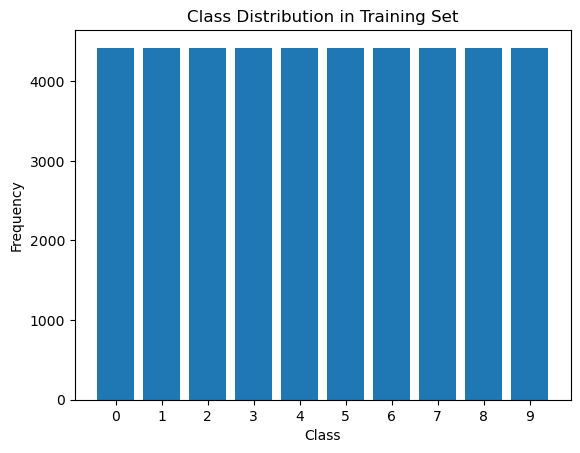

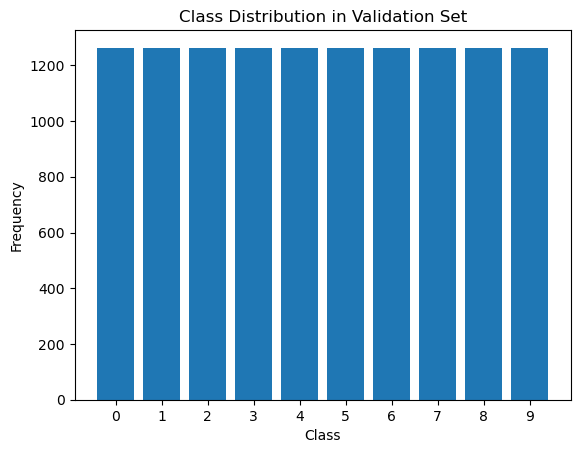

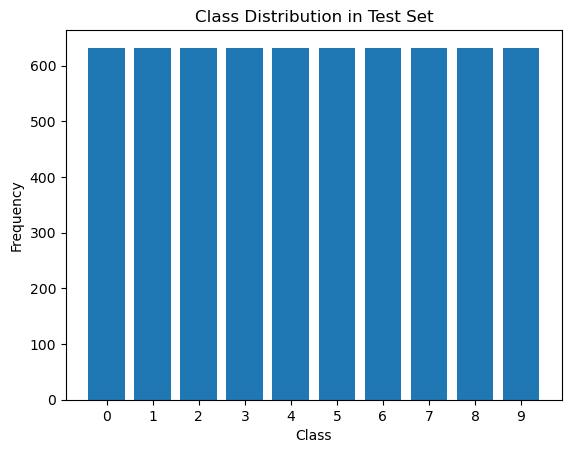

((44191, 10), (12626, 10), (6313, 10))

In [4]:
# Create a balanced dataset
x_balanced = np.empty((0, 28, 28))
y_balanced_flat = np.empty(0, dtype=int)
for i in range(10):
    indices = np.where(y_combined_flat == i)[0]
    balanced_indices = np.random.choice(indices, min_class_size, replace=False)
    x_balanced = np.vstack((x_balanced, x_combined[balanced_indices]))
    y_balanced_flat = np.concatenate((y_balanced_flat, y_combined_flat[balanced_indices]))

# Convert labels back to categorical
y_balanced = to_categorical(y_balanced_flat, 10)

# Split the balanced dataset into training (70%), validation (20%), and test (10%)
x_temp, x_test, y_temp, y_test = train_test_split(x_balanced, y_balanced, test_size=0.1, stratify=y_balanced_flat)
x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=(2/9), stratify=y_temp)

# Normalise the images to [0, 1]
x_train = x_train.astype('float32') / 255
x_val = x_val.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Reshape the images to add a dimension for the channel
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_val = x_val.reshape(x_val.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

# Function to plot class distribution
def plot_class_distribution(labels, dataset_name):
    # Count the number of each class
    class_counts = np.sum(labels, axis=0)
    # Plot
    plt.bar(range(10), class_counts)
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.title(f'Class Distribution in {dataset_name} Set')
    plt.xticks(range(10))
    plt.show()

# Plot the class distribution for each set
plot_class_distribution(y_train, 'Training')
plot_class_distribution(y_val, 'Validation')
plot_class_distribution(y_test, 'Test')
y_train.shape, y_val.shape, y_test.shape

Train the model

In [5]:
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPool2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation, RandomZoom, RandomTranslation, Resizing, RandomContrast
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
# TEST ON MNIST ONLY

# Reshape the images to add a dimension for the channel
x_train_combined = x_train.reshape(-1, 28, 28, 1)
x_val_combined = x_val.reshape(-1, 28, 28, 1)
x_test_combined = x_test.reshape(-1, 28, 28, 1)

y_train_combined = y_train
y_val_combined = y_val
y_test_combined = y_test

x_train_combined.shape, x_val_combined.shape, x_test_combined.shape

((44191, 28, 28, 1), (12626, 28, 28, 1), (6313, 28, 28, 1))

In [7]:
# Reshape the images to add a dimension for the channel
x_train_combined = x_train_combined.reshape(-1, 28, 28, 1)
x_val_combined = x_val_combined.reshape(-1, 28, 28, 1)
x_test_combined = x_test_combined.reshape(-1, 28, 28, 1)

x_train_combined.shape, x_val_combined.shape, x_test_combined.shape

((44191, 28, 28, 1), (12626, 28, 28, 1), (6313, 28, 28, 1))

50% chance of adding Gaussian noise, and just a tad each time.

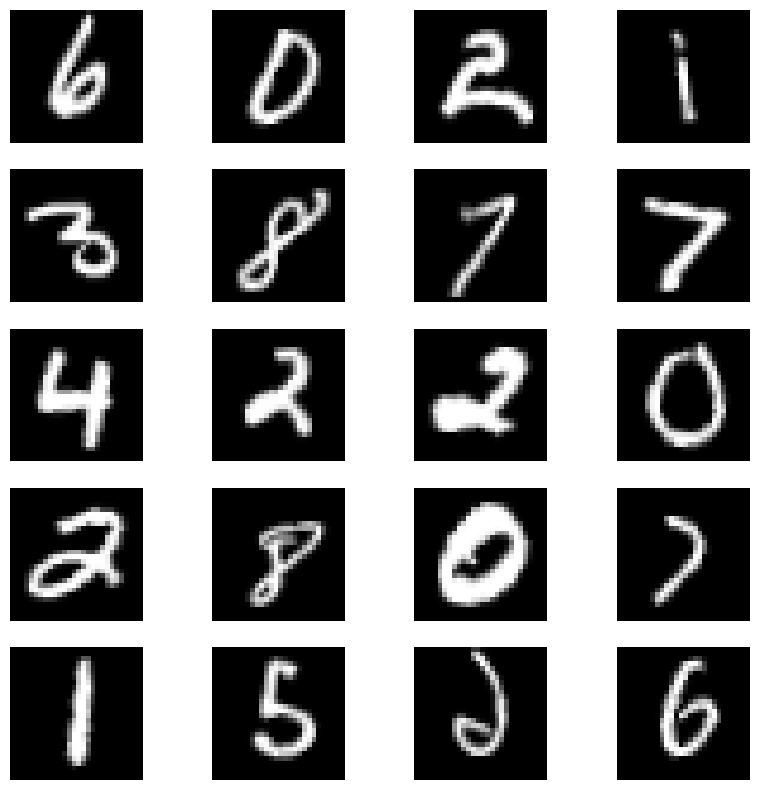

In [8]:
import random

def random_gaussian_noise(x):
    if random.random() < 0.5:  # 50% chance to add Gaussian noise
        scale = np.random.uniform(0.0001, 0.00000005)
        return x + np.random.normal(loc=0, scale=scale, size=x.shape)
    else:
        return x

datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=False,
    fill_mode='nearest',
    # featurewise_std_normalization=True,  # Normalize the dataset
    # preprocessing_function=random_gaussian_noise  # Add Gaussian noise
)

# Fit the data augmentation on the combined training dataset
datagen.fit(x_train_combined)

# Generate a batch of augmented images and labels
augmented_images, augmented_labels = next(datagen.flow(x_train_combined, y_train_combined, batch_size=64))

# Display the first image in the batch
plt.figure(figsize=(10,  10))
for i in range(20):  # Displaying  20 images in a  5x4 grid
    plt.subplot(5,  4, i +  1)
    plt.imshow(augmented_images[i].reshape(28,  28), cmap='gray')
    plt.axis('off')
plt.show()

In [9]:
# Define the CNN model
cnn_model_simplified = Sequential([
    # First Convolutional Block
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Second Convolutional Block (Removed third block to reduce complexity)
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Flattening the convolutions
    Flatten(),

    # Dense Layers (Reduced the number of neurons to lower the parameter count)
    Dense(256, activation='relu'),  # Reduced from 512 to 256
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),  # Reduced from 256 to 128
    BatchNormalization(),
    Dropout(0.5),

    # Output Layer
    Dense(10, activation='softmax')
])

# Compile the model
cnn_model_simplified.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

(44191, 28, 28, 1) (44191, 10)
(12626, 28, 28, 1) (12626, 10)


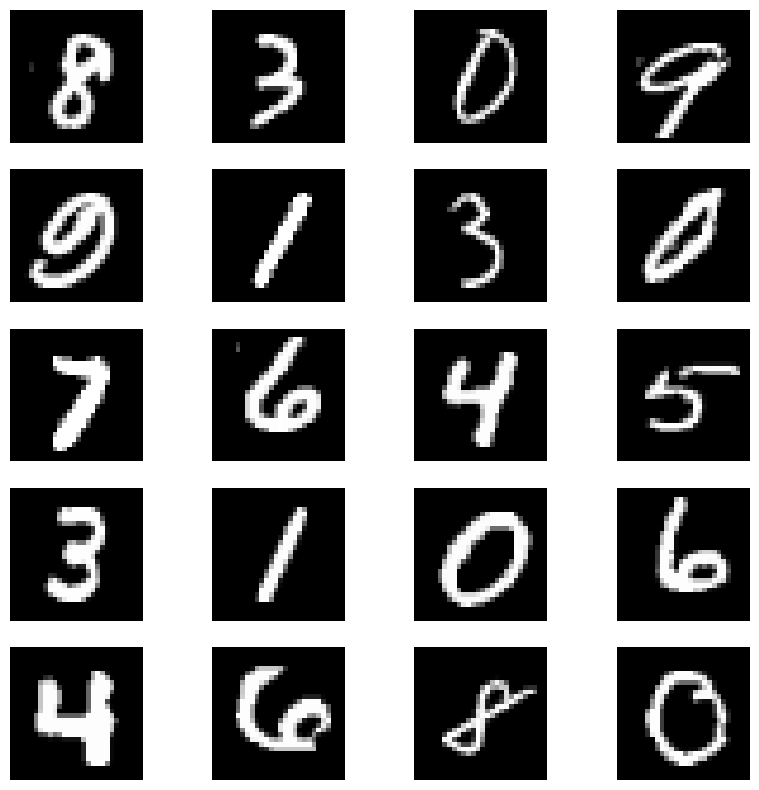

In [10]:
print(x_train_combined.shape, y_train_combined.shape)
print(x_val_combined.shape, y_val_combined.shape)

plt.figure(figsize=(10,  10))
for i in range(20):  # Displaying  20 images in a  5x4 grid
    plt.subplot(5,  4, i +  1)
    plt.imshow(x_val_combined[i].reshape(28,  28), cmap='gray')
    plt.axis('off')

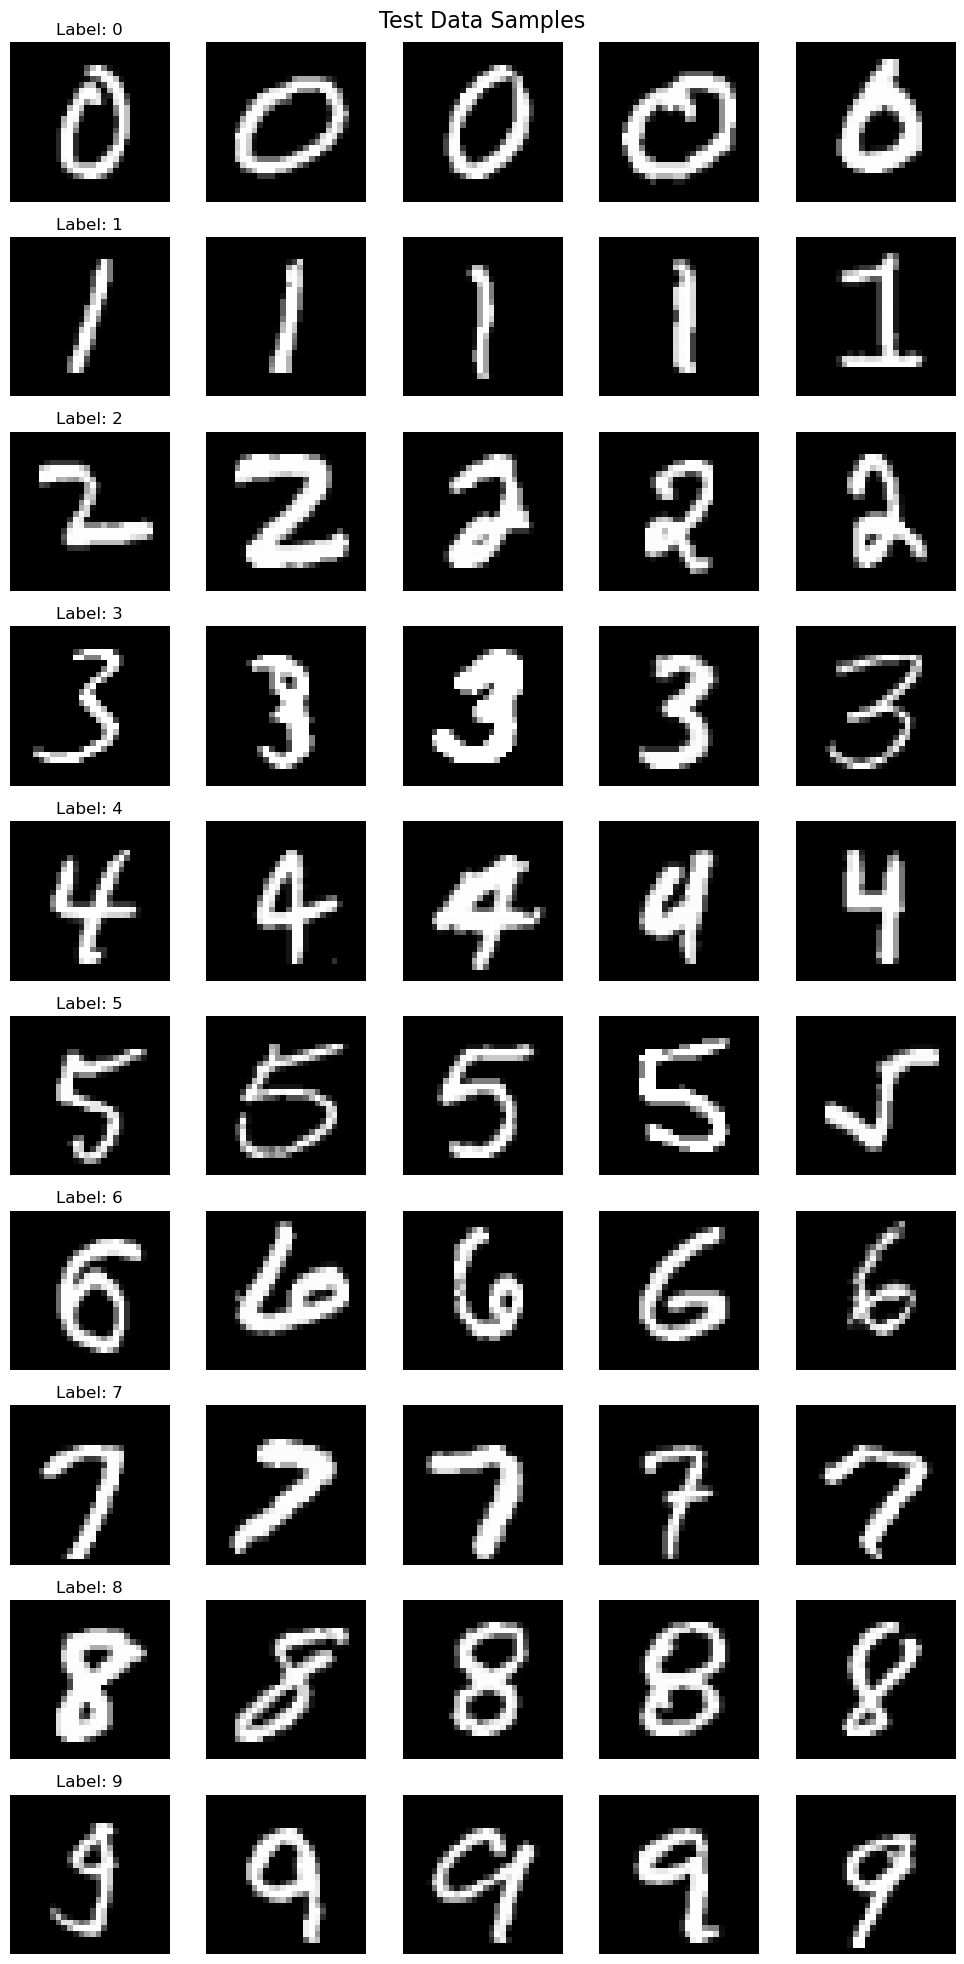

In [11]:
# Check the training and validation data are accurate

def plot_images_with_labels(images, labels, num_classes=10, title="Data", samples_per_class=5):
    fig, axes = plt.subplots(num_classes, samples_per_class, figsize=(2*samples_per_class, 2*num_classes))
    fig.suptitle(title, fontsize=16)
    axes = axes.flatten()
    
    for i in range(num_classes):
        # Find images of a specific class
        class_images = images[labels == i][:samples_per_class]
        
        for j, img in enumerate(class_images):
            idx = i * samples_per_class + j
            axes[idx].imshow(img.reshape(28, 28), cmap='gray')
            axes[idx].axis('off')
            if j == 0:
                axes[idx].set_title(f'Label: {i}')
    plt.tight_layout()
    plt.show()

# Assuming you have y_train_combined and y_test_combined as one-hot encoded labels
y_train_combined_categorical = np.argmax(y_train_combined, axis=1)
y_val_combined_categorical = np.argmax(y_val_combined, axis=1)
y_test_combined_categorical = np.argmax(y_test_combined, axis=1)

# Plot training data samples
# plot_images_with_labels(x_train_combined, y_train_combined_categorical, title="Training Data Samples")
# print('y')
# plot_images_with_labels(x_val_combined, y_val_combined_categorical, title="Validation Data Samples")
plot_images_with_labels(x_test_combined, y_test_combined_categorical, title="Test Data Samples")

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming x_train_combined already normalized but let's ensure its statistics are used for validation
mean = np.mean(x_train_combined)
std = np.std(x_train_combined)

# Normalize validation data using training data's statistics
x_val_combined = (x_val_combined - mean) / std

x_val_combined.shape

# Create a generator for validation data
validation_datagen = ImageDataGenerator(featurewise_std_normalization=True)

# Fit the generator to your training data to compute feature-wise normalization
validation_datagen.fit(x_train_combined)  # Use training data to compute mean and std

/Users/oscarmoxon/anaconda3/envs/NN/lib/python3.11/site-packages/keras/preprocessing/image.py:1460: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn(


Fit

In [13]:
history = cnn_model_simplified.fit(
    datagen.flow(x_train_combined, y_train_combined, batch_size=64), 
    epochs=10, 
    validation_data=(x_val_combined, y_val_combined)  # Ensure this data is correctly preprocessed
)

Epoch 1/10


2024-02-17 20:58:22.261028: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-17 20:58:22.265331: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


187/691 [=======>......................] - ETA: 7s - loss: 0.8975 - accuracy: 0.7181

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict classes with the model
val_predictions = cnn_model_simplified.predict(x_val_combined)
val_pred_classes = np.argmax(val_predictions, axis=1)
val_true_classes = np.argmax(y_val_combined, axis=1)

# Confusion Matrix
print(confusion_matrix(val_true_classes, val_pred_classes))

# Classification Report
print(classification_report(val_true_classes, val_pred_classes))

395/395 [==============================] - 1s 2ms/step
[[1249    0    0    0    0    1    3    1    7    2]
 [   1 1158   15    1    6    0   11    3   62    6]
 [   0    0 1251    1    0    1    0    2    8    0]
 [   0    0    2 1251    0    3    0    2    4    1]
 [   0    0    1    0 1223    0    3    1   13   22]
 [   2    0    0   11    0 1245    1    0    3    0]
 [   2    0    0    1    0    4 1243    0   12    0]
 [   0    0   10    0    3    1    0 1228    5   15]
 [   0    0    1    0    0    2    0    0 1258    1]
 [   4    0    0    1    2    0    0    3    7 1246]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1263
           1       1.00      0.92      0.96      1263
           2       0.98      0.99      0.98      1263
           3       0.99      0.99      0.99      1263
           4       0.99      0.97      0.98      1263
           5       0.99      0.99      0.99      1262
           6       0.99      0.98  

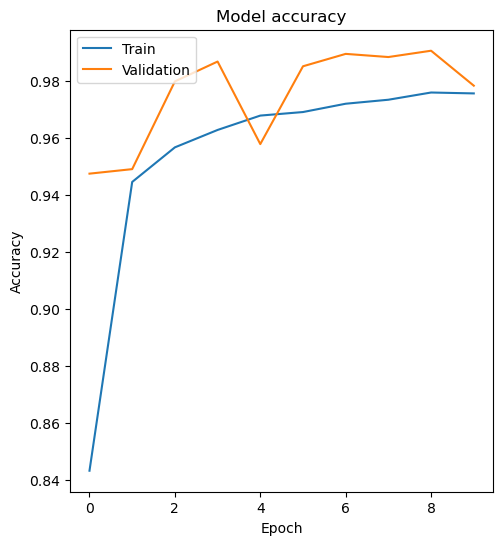

In [ ]:
# Plot training and validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

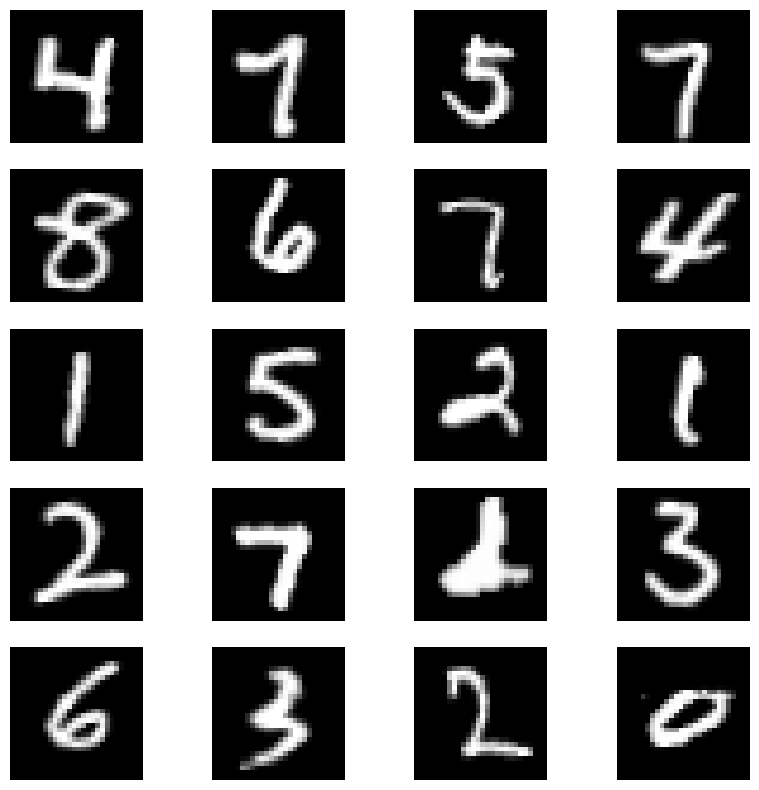

In [ ]:
import random

def random_gaussian_noise(x):
    if random.random() < 0.5:  # 50% chance to add Gaussian noise
        scale = np.random.uniform(0.00000005, 0)
        return x + np.random.normal(loc=0, scale=scale, size=x.shape)
    else:
        return x

datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=False,
    fill_mode='nearest',
    # featurewise_std_normalization=True,  # Normalize the dataset
    # preprocessing_function=random_gaussian_noise  # Add Gaussian noise
)

# Fit the data augmentation on the combined training dataset
datagen.fit(x_train_combined)

# Generate a batch of augmented images and labels
augmented_images, augmented_labels = next(datagen.flow(x_train_combined, y_train_combined, batch_size=64))

# Display the first image in the batch
plt.figure(figsize=(10,  10))
for i in range(20):  # Displaying  20 images in a  5x4 grid
    plt.subplot(5,  4, i +  1)
    plt.imshow(augmented_images[i].reshape(28,  28), cmap='gray')
    plt.axis('off')
plt.show()

In [ ]:
# Define the CNN model
cnn_model_gauss = Sequential([
    # First Convolutional Block
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Second Convolutional Block (Removed third block to reduce complexity)
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Flattening the convolutions
    Flatten(),

    # Dense Layers (Reduced the number of neurons to lower the parameter count)
    Dense(256, activation='relu'),  # Reduced from 512 to 256
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),  # Reduced from 256 to 128
    BatchNormalization(),
    Dropout(0.5),

    # Output Layer
    Dense(10, activation='softmax')
])

# Compile the model
cnn_model_gauss.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_gauss = cnn_model_gauss.fit(
    datagen.flow(x_train_combined, y_train_combined, batch_size=64), 
    epochs=10, 
    validation_data=(x_val_combined, y_val_combined)  # Ensure this data is correctly preprocessed
)

Epoch 1/10


2024-02-17 20:40:26.913731: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


691/691 [==============================] - 14s 18ms/step - loss: 0.4604 - accuracy: 0.8563 - val_loss: 0.1426 - val_accuracy: 0.9638
Epoch 2/10
691/691 [==============================] - 10s 15ms/step - loss: 0.1738 - accuracy: 0.9477 - val_loss: 0.0891 - val_accuracy: 0.9744
Epoch 3/10
691/691 [==============================] - 11s 16ms/step - loss: 0.1384 - accuracy: 0.9574 - val_loss: 0.0680 - val_accuracy: 0.9788
Epoch 4/10
691/691 [==============================] - 11s 16ms/step - loss: 0.1199 - accuracy: 0.9644 - val_loss: 0.0570 - val_accuracy: 0.9831
Epoch 5/10
691/691 [==============================] - 11s 16ms/step - loss: 0.1045 - accuracy: 0.9690 - val_loss: 0.0415 - val_accuracy: 0.9880
Epoch 6/10
691/691 [==============================] - 12s 17ms/step - loss: 0.0935 - accuracy: 0.9707 - val_loss: 0.0432 - val_accuracy: 0.9871
Epoch 7/10
691/691 [==============================] - 11s 16ms/step - loss: 0.0936 - accuracy: 0.9726 - val_loss: 0.0425 - val_accuracy: 0.9875
Epo

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict classes with the model
val_predictions = cnn_model_gauss.predict(x_val_combined)
val_pred_classes = np.argmax(val_predictions, axis=1)
val_true_classes = np.argmax(y_val_combined, axis=1)

# Confusion Matrix
print(confusion_matrix(val_true_classes, val_pred_classes))

# Classification Report
print(classification_report(val_true_classes, val_pred_classes))

395/395 [==============================] - 1s 3ms/step
[[1252    0    0    2    0    0    4    3    0    2]
 [   0 1261    1    0    0    0    0    1    0    0]
 [   0    3 1245    1    1    0    0   13    0    0]
 [   0    0    3 1245    0    6    0    8    0    1]
 [   0    3    0    0 1243    0    3    8    1    5]
 [   2    1    0    4    0 1252    2    0    1    0]
 [   2    1    0    0    0    0 1259    0    0    0]
 [   0    5    2    0    0    1    0 1254    0    0]
 [   1   13    3    0    1   10    5    2 1221    6]
 [   3    6    0    0    9    2    0   15    0 1228]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1263
           1       0.98      1.00      0.99      1263
           2       0.99      0.99      0.99      1263
           3       0.99      0.99      0.99      1263
           4       0.99      0.98      0.99      1263
           5       0.99      0.99      0.99      1262
           6       0.99      1.00  

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict classes with the model
test_predictions = cnn_model_gauss.predict(x_test_combined)
test_pred_classes = np.argmax(test_predictions, axis=1)
test_true_classes = np.argmax(y_test_combined, axis=1)

# Confusion Matrix
print(confusion_matrix(test_true_classes, test_pred_classes))

# Classification Report
print(classification_report(test_true_classes, test_pred_classes))

198/198 [==============================] - 1s 3ms/step
[[625   1   0   0   0   1   2   0   1   1]
 [  0 627   0   0   0   0   0   4   0   0]
 [  0   1 624   2   0   0   0   4   0   0]
 [  0   0   0 623   0   3   0   2   2   1]
 [  0   2   0   0 628   0   1   0   0   0]
 [  1   0   1   2   0 624   2   1   0   1]
 [  1   1   0   0   1   2 627   0   0   0]
 [  0   2   1   0   2   0   0 627   0   0]
 [  2   3   1   2   0   3   0   3 614   3]
 [  3   1   0   0   6   2   0   6   1 612]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       631
           1       0.98      0.99      0.99       631
           2       1.00      0.99      0.99       631
           3       0.99      0.99      0.99       631
           4       0.99      1.00      0.99       631
           5       0.98      0.99      0.99       632
           6       0.99      0.99      0.99       632
           7       0.97      0.99      0.98       632
           8       0.99    

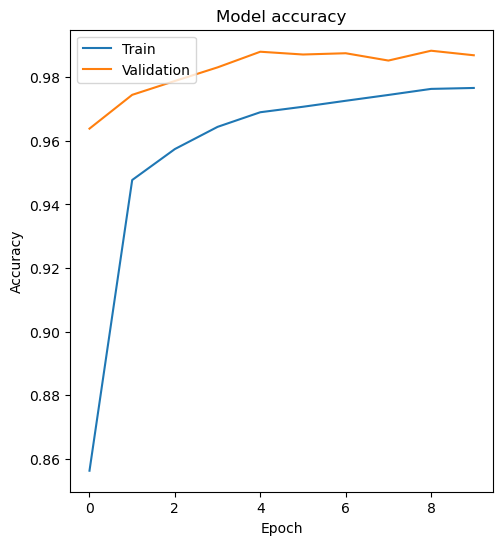

In [ ]:
# Plot training and validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_gauss.history['accuracy'])
plt.plot(history_gauss.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# EMNIST

In [ ]:
from emnist import extract_training_samples, extract_test_samples

# Load EMNIST data
emnist_images, emnist_labels = extract_training_samples('digits')
emnist_test_images, emnist_test_labels = extract_test_samples('digits')

# Normalize the images to [0, 1]
emnist_images = emnist_images.astype('float32') / 255
emnist_test_images = emnist_test_images.astype('float32') / 255

# Convert labels to one-hot encoding`
# emnist_labels = to_categorical(emnist_labels, 10)
# emnist_test_labels = to_categorical(emnist_test_labels, 10)

# Reshape the images to add a dimension for the channel
emnist_images = emnist_images.reshape(emnist_images.shape[0], 28, 28, 1)
emnist_test_images = emnist_test_images.reshape(emnist_test_images.shape[0], 28, 28, 1)

emnist_images.shape, emnist_labels.shape

((240000, 28, 28, 1), (240000,))

In [ ]:
# Assuming emnist_test_labels is already loaded and is a flat array of labels (not one-hot encoded)
unique_classes = np.unique(emnist_test_labels)
sample_per_class = 2400
balanced_indices = []
for cls in unique_classes:
    cls_indices = np.where(emnist_test_labels == cls)[0]
    cls_sample_indices = np.random.choice(cls_indices, sample_per_class, replace=False)
    balanced_indices.extend(cls_sample_indices)

# Now, extract the images and labels using the indices
emnist_x_balanced = emnist_test_images[balanced_indices]
emnist_y_balanced = emnist_test_labels[balanced_indices]
# emnist_x_balanced.shape, emnist_y_balanced.shape

# Normalize, reshape, and convert labels to one-hot encoding as necessary
emnist_x_balanced = emnist_x_balanced.astype('float32') / 255
emnist_x_balanced = emnist_x_balanced.reshape(-1, 28, 28, 1)
# emnist_y_balanced_one_hot = to_categorical(emnist_y_balanced, 10)

# Split the balanced dataset into training (70%), validation (20%), and test (10%)
ex_temp, ex_test, ey_temp, ey_test = train_test_split(emnist_x_balanced, emnist_y_balanced, test_size=0.1, stratify=emnist_y_balanced)
ex_train, ex_val, ey_train, ey_val = train_test_split(ex_temp, ey_temp, test_size=(4/9), stratify=ey_temp)

In [ ]:
# Reshape the images to add a dimension for the channel
ex_train_combined = ex_train.reshape(-1, 28, 28, 1)
ex_val_combined = ex_val.reshape(-1, 28, 28, 1)
ex_test_combined = ex_test.reshape(-1, 28, 28, 1)

ey_train_combined = ey_train
ey_val_combined = ey_val
ey_test_combined = ey_test

ex_train_combined.shape, ex_val_combined.shape, ex_test_combined.shape

((12000, 28, 28, 1), (9600, 28, 28, 1), (2400, 28, 28, 1))

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict classes with the model
eval_predictions = cnn_model_gauss.predict(ex_val_combined)
eval_pred_classes = np.argmax(eval_predictions, axis=1)
eval_true_classes = ey_val_combined

# Confusion Matrix
print(confusion_matrix(eval_true_classes, eval_pred_classes))

# Classification Report
print(classification_report(eval_true_classes, eval_pred_classes))

300/300 [==============================] - 1s 2ms/step
[[951   3   0   0   0   0   3   0   0   3]
 [  0 954   0   0   0   1   4   1   0   0]
 [  2   8 939   5   1   0   0   5   0   0]
 [  0   2   5 934   0  17   0   2   0   0]
 [  2  17   2   0 908   1   1  27   2   0]
 [  1   2   0   1   0 945   0  10   1   0]
 [  3  10   9   0   1   3 934   0   0   0]
 [  1  39  27   1   0   0   0 891   0   1]
 [  8  16   8  10   4  21  12   6 872   3]
 [  0  15   2   2  76   3   0 230  11 621]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       960
           1       0.89      0.99      0.94       960
           2       0.95      0.98      0.96       960
           3       0.98      0.97      0.98       960
           4       0.92      0.95      0.93       960
           5       0.95      0.98      0.97       960
           6       0.98      0.97      0.98       960
           7       0.76      0.93      0.84       960
           8       0.98    

NameError: name 'model' is not defined